# Solar Weather Lab: Predicting Sunspot Activity

## Introduction
Have you ever wondered how the Sun's activity influences space weather and even life on Earth? Sunspots — dark, cooler regions on the Sun’s surface - are closely tied to solar storms that can disrupt satellites, GPS, and even power grids. Understanding and predicting sunspot activity is crucial for space weather forecasting.

In this lab, you’ll experiment with sequence modeling using some of the techniques we have covered in class to predict sunspot numbers. We'll use real NASA data and train various sequence models, including Recurrent Neural Networks (RNNs), Gated Recurrent Units (GRUs), Long Short-Term Memory (LSTM) networks, and the state-of-the-art Mamba model. You will fine-tune these models and optimize hyperparameters to improve RMSE accuracy. By the end, you’ll gain hands-on experience with time series forecasting and sequence learning, all while unraveling the mysteries of our star!

## Objectives
- Fetch and preprocess real-world NASA Sunspot data.
- Apply sequence modeling techniques for time series forecasting.
- Implement and train RNN, GRU, LSTM, and Mamba models using PyTorch.
- Tune hyperparameters and optimize models for improved RMSE accuracy.
- Evaluate model performance and visualize predictions.

## Prerequisites
Before starting, ensure you have:
- Basic knowledge of Python and PyTorch.
- Familiarity with neural networks and sequence modeling (RNNs, GRUs, LSTMs, Mamba).
- Experience with data preprocessing and time series analysis.

## Dataset
We will use NASA’s **Sunspot & Solar Weather Data**, fetched from:
[NOAA Solar Cycle Sunspots JSON](https://services.swpc.noaa.gov/json/solar-cycle/sunspots.json)
This dataset includes historical sunspot counts and solar flux data, essential for understanding solar activity cycles.

---

## Lab Steps

### Preprocessing
   - Retrieve the NASA’s **Sunspot & Solar Weather Data**.  
   - Normalize the data and handle missing values (minmax scaler is provided).  
   - Convert the dataset into sequences (48 past time steps are provided)


### Implement Sequence Models

You will implement and compare the following models:

- **Simple RNN**
 - Implement a single-layer RNN to process seismic time-series data.
 - Train and evaluate performance.

- **Long Short-Term Memory (LSTM) - this is provided**
 - Implement an LSTM-based model to capture long-range dependencies.
 - Compare results with the simple RNN model.

- **Gated Recurrent Unit (GRU)**
 - Implement a GRU model and analyze its efficiency in training and generalization.


### Evaluation and insights
- **Compare Model Performance**  
   - Train all models using the same dataset split.  
   - Evaluate using RMSE.
   - Evaluate performance in terms of training time vs inference time.
   - Visualize loss curves and performance metrics.
   - Compare how different architectures handle sequence modeling.
   - Discuss challenges such as overfitting and vanishing gradients.


---

### **Deliverables**
- Notebook with code and explanations.
- Report summarizing findings and insights, include visualizations comparing model predictions.

---



In [1]:
!pip install mamba-ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.3-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  

In [7]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.metrics import mean_squared_error, r2_score
from mamba_ssm import Mamba
import torch.backends.cudnn as cudnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        return self.fc(rnn_out[:, -1, :])

class LSTMLayerNormModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(LSTMLayerNormModel, self).__init__()
        # uncomment for LSTM
        #cudnn.enabled = False
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.layer_norm(lstm_out[:, -1, :])
        return self.fc(lstm_out)

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])

class MambaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1, num_layers=2):
        super(MambaModel, self).__init__()
        self.mamba = Mamba(d_model=hidden_dim, d_state=32, d_conv=4, expand=2)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.mamba(x)
        return self.fc2(x[:, -1, :])

#Sequence Data Preparation
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Combined loss function
def combined_loss(predictions, targets, alpha=.5):
    mse = torch.nn.functional.mse_loss(predictions, targets)
    rmse = torch.sqrt(mse)
    return alpha * mse + (1 - alpha) * rmse

#Training Loop
def train_model(model, train_loader, val_loader, epochs=10, alpha=.5):
    model.to(device)  # Ensure model is on the correct device
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []

    start_time = time.time()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch to device
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = combined_loss(predictions, y_batch, alpha)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)  # Move to device
                val_preds = model(X_val)
                val_loss += combined_loss(val_preds, y_val, alpha).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    return train_losses, val_losses, training_time

# Testing loop
def evaluate(model, test_loader):
    model.to(device)
    model.eval()
    y_pred, y_true = [], []
    inference_start_time = time.time()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y_batch.cpu().numpy())
    inference_time = time.time() - inference_start_time
    print(f"Inference time: {inference_time:.4f} seconds")

    y_pred, y_true = np.array(y_pred), np.array(y_true)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.4f}, R² Score: {r2:.4f}")
    return y_pred, y_true, inference_time, rmse, r2



def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, 0], label="Actual", linestyle="dashed")
    plt.plot(y_pred[:, 0], label="Predicted")
    plt.legend()
    plt.title(title)
    plt.show()

def plot_loss(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss (Combined MSE + RMSE)")
    plt.plot(val_losses, label="Validation Loss", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Training and Validation Loss")
    plt.legend()
    plt.show()


url = "https://services.swpc.noaa.gov/json/solar-cycle/sunspots.json"
response = requests.get(url)

if response.status_code == 200:
    raw_data = response.json()
else:
    print(f"Error {response.status_code}: Unable to fetch data")
    raw_data = []

# Preprocessing
df = pd.DataFrame(raw_data)
print(df.head())
df['time-tag'] = pd.to_datetime(df['time-tag'])
df.set_index('time-tag', inplace=True)
df = df[['ssn']]  # Selecting relevant features


# Split data into training, validation and testing sets
train_size = int(len(df) * 0.7)  # 70% for training
val_size = int(len(df) * 0.1)    # 10% for validation
test_size = len(df) - train_size - val_size  # 20% for testing

df_train = df.iloc[:train_size]
df_val = df.iloc[train_size:train_size+val_size]
df_test = df.iloc[train_size+val_size:]

# Normalize data
scaler = MinMaxScaler()
df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
df_val[df_val.columns] = scaler.transform(df_val[df_val.columns])
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns])

sequence_length = 48  # Using past 48 timesteps
data_train_array = df_train.values
data_test_array = df_test.values
data_val_array = df_val.values

X_train, y_train = create_sequences(data_train_array, sequence_length)
X_test, y_test = create_sequences(data_test_array, sequence_length)
X_val, y_val = create_sequences(data_val_array, sequence_length)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)





Using device: cuda
  time-tag    ssn
0  1749-01   96.7
1  1749-02  104.3
2  1749-03  116.7
3  1749-04   92.8
4  1749-05  141.7


<ipython-input-7-52777006d952>:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
<ipython-input-7-52777006d952>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[df_val.columns] = scaler.transform(df_val[df_val.columns])
<ipython-input-7-52777006d952>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Epoch 1/10, Train Loss: 0.057501, Val Loss: 0.006521
Epoch 2/10, Train Loss: 0.005096, Val Loss: 0.006154
Epoch 3/10, Train Loss: 0.004798, Val Loss: 0.005717
Epoch 4/10, Train Loss: 0.004693, Val Loss: 0.005514
Epoch 5/10, Train Loss: 0.004578, Val Loss: 0.006219
Epoch 6/10, Train Loss: 0.004804, Val Loss: 0.005657
Epoch 7/10, Train Loss: 0.005490, Val Loss: 0.005456
Epoch 8/10, Train Loss: 0.005103, Val Loss: 0.006589
Epoch 9/10, Train Loss: 0.004557, Val Loss: 0.005135
Epoch 10/10, Train Loss: 0.004527, Val Loss: 0.006717
Training time: 22.39 seconds
Inference time: 0.1393 seconds
RMSE: 0.0669, R² Score: 0.8568


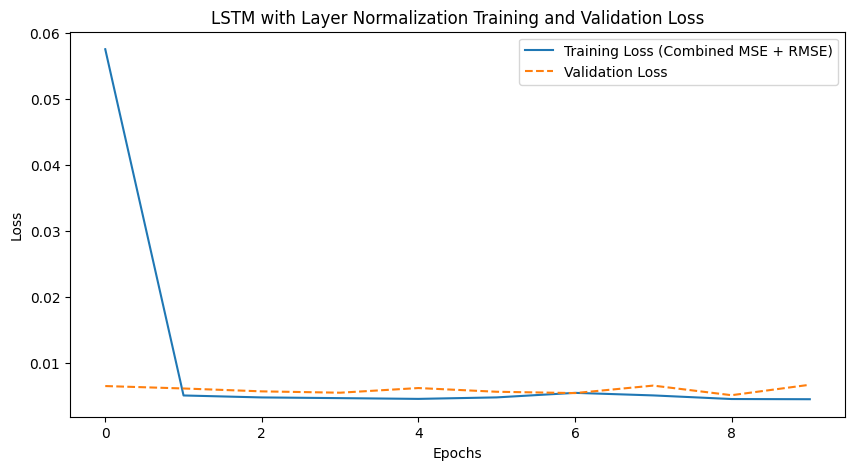

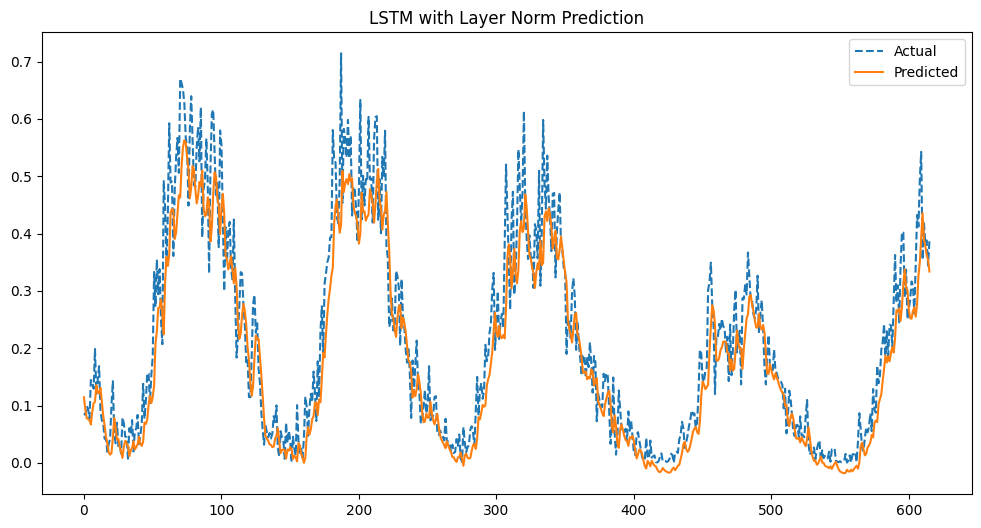

In [11]:
model = LSTMLayerNormModel(input_dim=df.shape[1], hidden_dim=128, output_dim=df.shape[1]).to(device)
train_losses, val_losses, time_lstm = train_model(model, train_loader, val_loader, epochs=10)
y_pred, y_true, inf_time, rmse, r2 = evaluate(model, test_loader)
plot_loss(train_losses, val_losses, "LSTM with Layer Normalization")
plot_results(y_true, y_pred, "LSTM with Layer Norm Prediction")

Epoch 1/10, Train Loss: 0.075013, Val Loss: 0.038804
Epoch 2/10, Train Loss: 0.035583, Val Loss: 0.048578
Epoch 3/10, Train Loss: 0.037129, Val Loss: 0.039948
Epoch 4/10, Train Loss: 0.034285, Val Loss: 0.038545
Epoch 5/10, Train Loss: 0.034530, Val Loss: 0.038059
Epoch 6/10, Train Loss: 0.034833, Val Loss: 0.037555
Epoch 7/10, Train Loss: 0.034306, Val Loss: 0.038129
Epoch 8/10, Train Loss: 0.034753, Val Loss: 0.035710
Epoch 9/10, Train Loss: 0.034012, Val Loss: 0.035532
Epoch 10/10, Train Loss: 0.034608, Val Loss: 0.035268
Training time: 5.35 seconds
Inference time: 0.0379 seconds
RMSE: 0.0580, R² Score: 0.8923


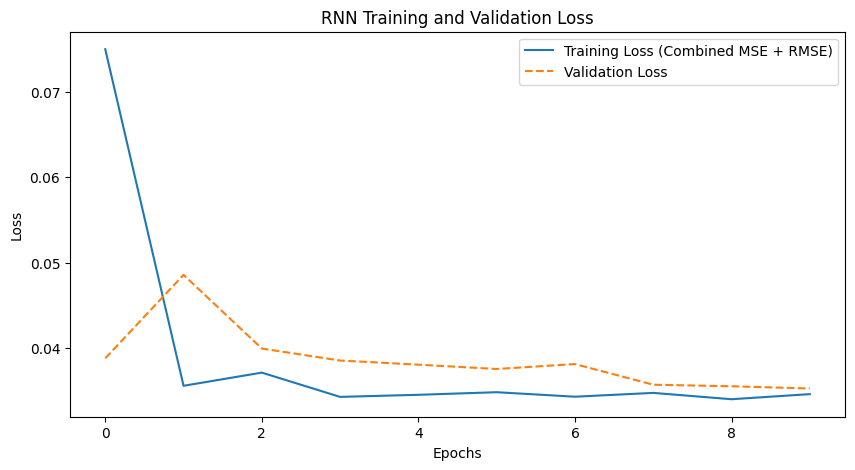

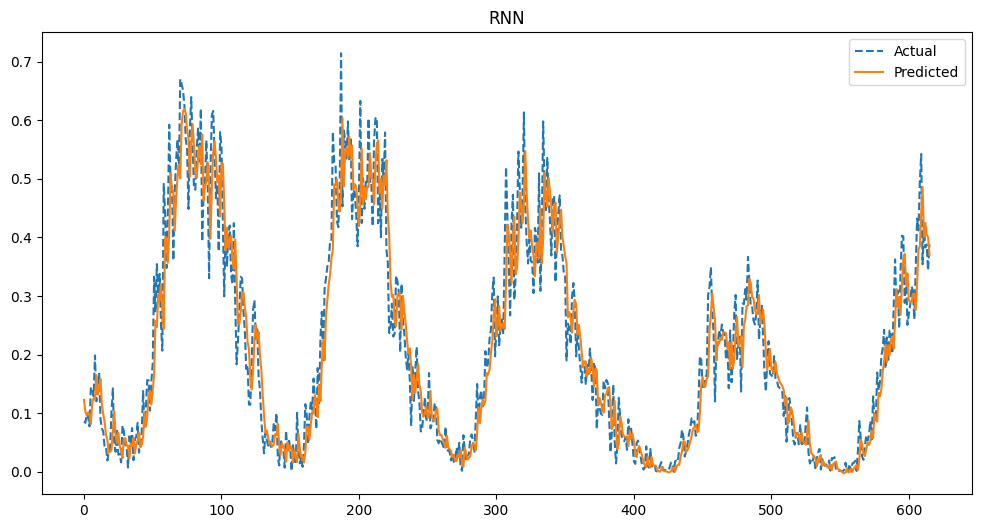

In [ ]:
model = RNNModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
train_losses, val_losses, time_rnn = train_model(model, train_loader, val_loader, epochs=10)
y_pred, y_true, inf_time, rmse, r2 = evaluate(model, test_loader)
plot_loss(train_losses, val_losses, "RNN")
plot_results(y_true, y_pred, "RNN")

In [ ]:
model = GRUModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
train_losses, val_losses, time_gru = train_model(model, train_loader, val_loader, epochs=10)
y_pred, y_true, inf_time, rmse, r2 = evaluate(model, test_loader)
plot_loss(train_losses, val_losses, "GRU")
plot_results(y_true, y_pred, "GRU")

Epoch 1/10, Train Loss: 0.079202, Val Loss: 0.054981


RuntimeError: cudnn RNN backward can only be called in training mode

Epoch 1/10, Train Loss: 0.075721, Val Loss: 0.050820
Epoch 2/10, Train Loss: 0.039273, Val Loss: 0.042290
Epoch 3/10, Train Loss: 0.036447, Val Loss: 0.039914
Epoch 4/10, Train Loss: 0.035091, Val Loss: 0.037293
Epoch 5/10, Train Loss: 0.034592, Val Loss: 0.036044
Epoch 6/10, Train Loss: 0.034608, Val Loss: 0.036041
Epoch 7/10, Train Loss: 0.034035, Val Loss: 0.037787
Epoch 8/10, Train Loss: 0.033613, Val Loss: 0.034777
Epoch 9/10, Train Loss: 0.033633, Val Loss: 0.035199
Epoch 10/10, Train Loss: 0.033540, Val Loss: 0.034958
Training time: 1.97 seconds
Inference time: 0.0229 seconds
RMSE: 0.0578, R² Score: 0.8931


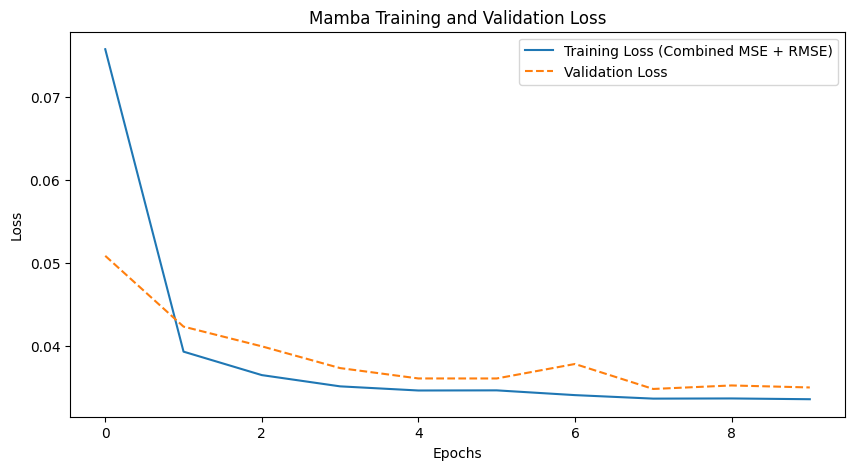

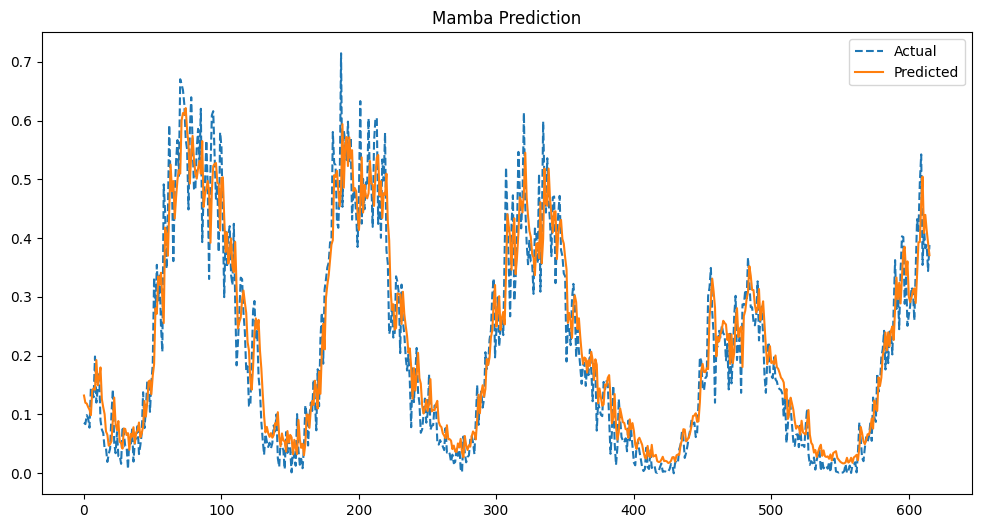

In [9]:
mamba_model = MambaModel(input_dim=df.shape[1], hidden_dim=32, output_dim=df.shape[1])
train_losses, val_losses, time_mamba = train_model(mamba_model, train_loader, val_loader, epochs=10)
y_pred, y_true, inf_time, rmse, r2 = evaluate(mamba_model, test_loader)
plot_loss(train_losses, val_losses, "Mamba")
plot_results(y_true, y_pred, "Mamba Prediction")